### IMPORTY  

In [119]:
import queue
import numpy as np
from typing import List, Tuple
import math
import datetime
import pandas as pd
import itertools
from random_gen import RandomNumberGenerator2
import time
from multiprocessing import Pool, cpu_count
import random
import matplotlib.pyplot as plt
import json
import pickle

### GENERACJA DANYCH

In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)
INPUT_SIZE = 100
   
random_gen = RandomNumberGenerator2(seedVaule=seed) # type: ignore
p, d = random_gen.generate_input(INPUT_SIZE)

### ALGORYTM

In [121]:
class AlgorithmSA:
    def __init__(self, 
                 iterations:int,
                 alpha=0.995
                 ):
        self.iterations = iterations
        self.alpha = alpha
        
        
    def eval_end_times(self, p) -> List:
        C = []
        length = p[0].shape[0]
        for i in range(length):
            if i == 0:
                C.append(p[0][i] + p[1][i] + p[2][i])
            else:
                tmp = C[i-1] + p[0][i] + p[1][i] + p[2][i]
                C.append(tmp)
        return C
        
        
    def eval_criterion(self, p, d) -> Tuple:
        kry_3 = None
        kry_4 = 0
        C = self.eval_end_times(p)
        length = p[0].shape[0]
        for i in range(length):
            diff = max(C[i] - d[i], 0)
            if kry_3 is None or kry_3 < diff:
                kry_3 = diff
            kry_4 += diff                
        return [kry_3, kry_4]        
        
        
    
    def get_initial(self, p, d):
        length = len(p[0])
        new_order = np.random.permutation(length)
        p = [p[0][new_order], p[1][new_order], p[2][new_order]]
        d = d[new_order]
        return p, d
    
    def get_neighbor(self, p, d):
        neighbor = p.copy()
        i, j = random.sample(range(p[0].shape[0]), 2)
        neighbor[0][i], neighbor[0][j] = neighbor[0][j], neighbor[0][i]
        neighbor[1][i], neighbor[1][j] = neighbor[1][j], neighbor[1][i]
        neighbor[2][i], neighbor[2][j] = neighbor[2][j], neighbor[2][i]
        
        neighbor_d = d.copy()
        neighbor_d[i], neighbor_d[j] = neighbor_d[j], neighbor_d[i]
        return neighbor, neighbor_d
                        
    def dominates(self, a, b):
        return (a[0] <= b[0] and a[1] <= b[1]) and (a[0] < b[0] or a[1] < b[1])
    
    def calc_prob(self, it):
        try:
            return math.pow(self.alpha, it)
        except Exception as e:
            return 0.0001
    
    def run(self, p, d):
        P = []
        it = 0
        p, d = self.get_initial(p, d)
        x = self.eval_criterion(p, d)
        P.append(x)
        
        while it < self.iterations:
            p_neigh, d_neigh = self.get_neighbor(p, d)
            x_prim = self.eval_criterion(p_neigh, d_neigh)
            
            if self.dominates(x_prim, x):
                p = p_neigh
                d = d_neigh
                x = x_prim
                P.append(x)
            elif (random.random() < self.calc_prob(it)):
                p = p_neigh
                d = d_neigh
                x = x_prim
                P.append(x)
            it += 1
            
        # Pareto
        F = P.copy()
        for a in range(len(F)):
            for b in range(len(F)):
                if F[a] is not None and F[b] is not None and a != b and self.dominates(F[b], F[a]):
                    F[a] = None
                    break
        F = [f for f in F if f is not None]
        F = np.array(F)
        
        return F, P

### ZAPISANIE WYNIKÓW - WYWOŁANIE ALGORYTMU

In [123]:
max_iters = [100, 200, 400, 800, 1600]
REPETITIONS = 10

results = []
results_for_hvi = [[] for _ in max_iters]

# Gathering results for different max iterations
for i, iters in enumerate(max_iters):
    algorithm = AlgorithmSA(iterations=iters)
    F, P = algorithm.run(p, d)
    results.append((iters, F, P))
    results_for_hvi[i].append((0, F, P))

    for j in range(1, REPETITIONS):
        F, P = algorithm.run(p, d)
        results_for_hvi[i].append((j, F, P))
    

In [124]:
def create_paths(dir, n: int):
    return f'{dir}/n_{n}_results.pkl', f'{dir}/n_{n}_results_for_hvi.pkl'

DIR = 'res/zad1'
RESULTS_PATH, RESULTS_FOR_HVI_PATH = create_paths(DIR, INPUT_SIZE)

In [125]:
with open(RESULTS_PATH, 'wb') as f:
    pickle.dump(results, f)

with open(RESULTS_FOR_HVI_PATH, 'wb') as f:
    pickle.dump(results_for_hvi, f)

### LOAD DATA

In [126]:
with open(RESULTS_PATH, 'rb') as f:
    results_loaded = pickle.load(f)

with open(RESULTS_FOR_HVI_PATH, 'rb') as f:
    results_for_hvi_loaded = pickle.load(f)

### WYKRESY ZIOBRÓW (P) I FRONTÓW PARETO (F)

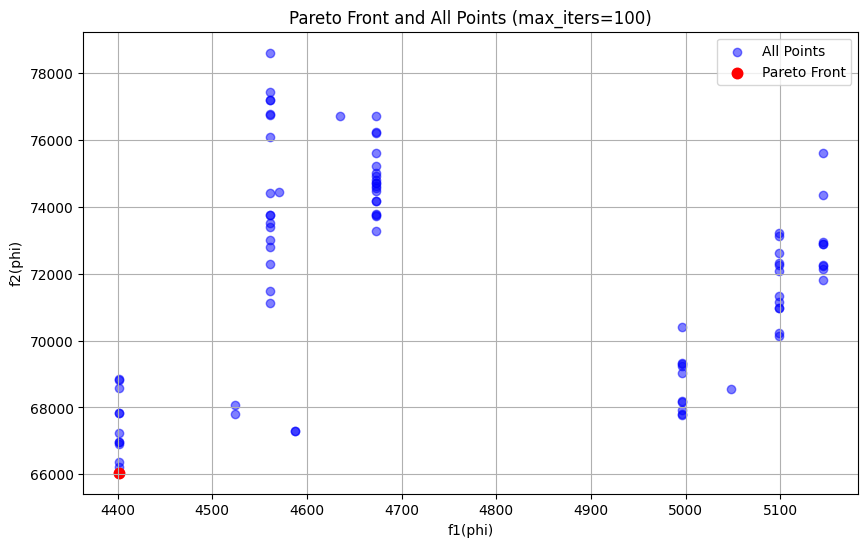

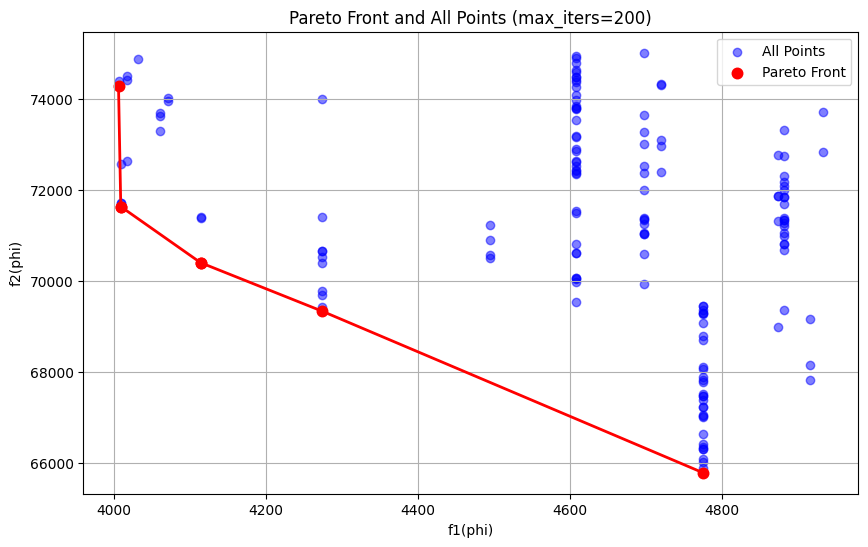

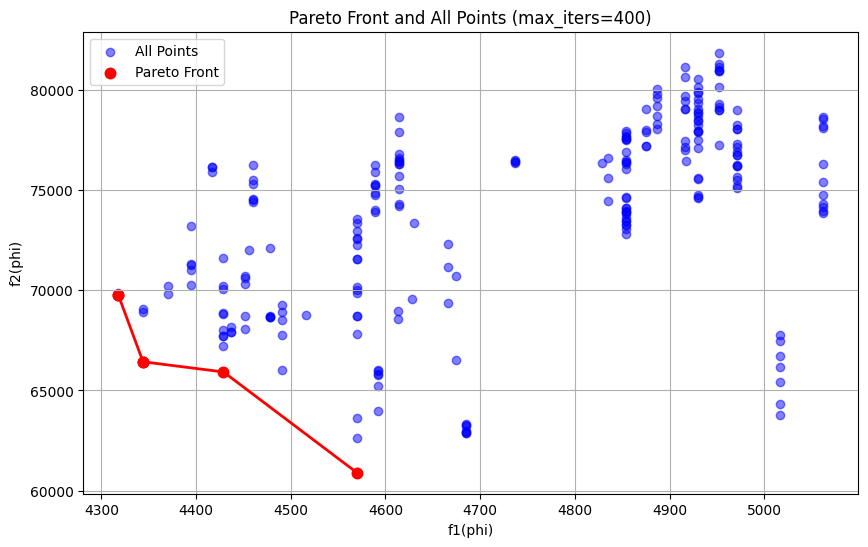

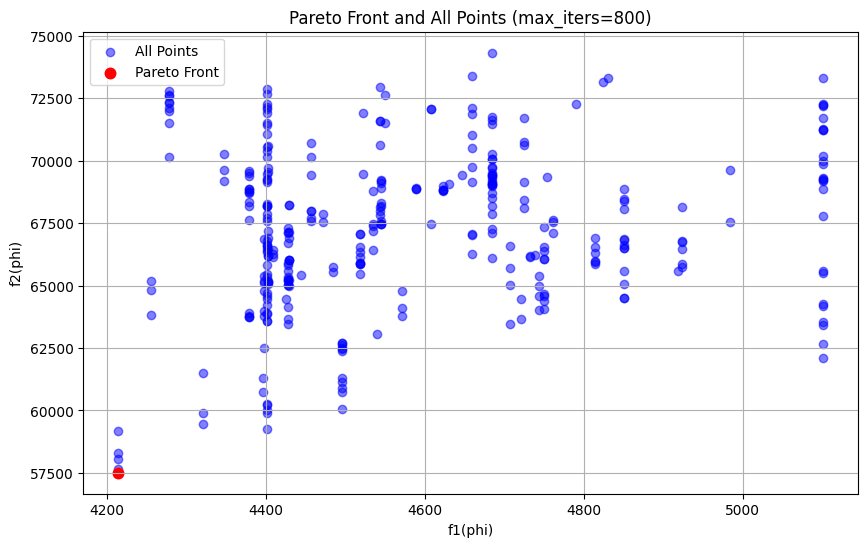

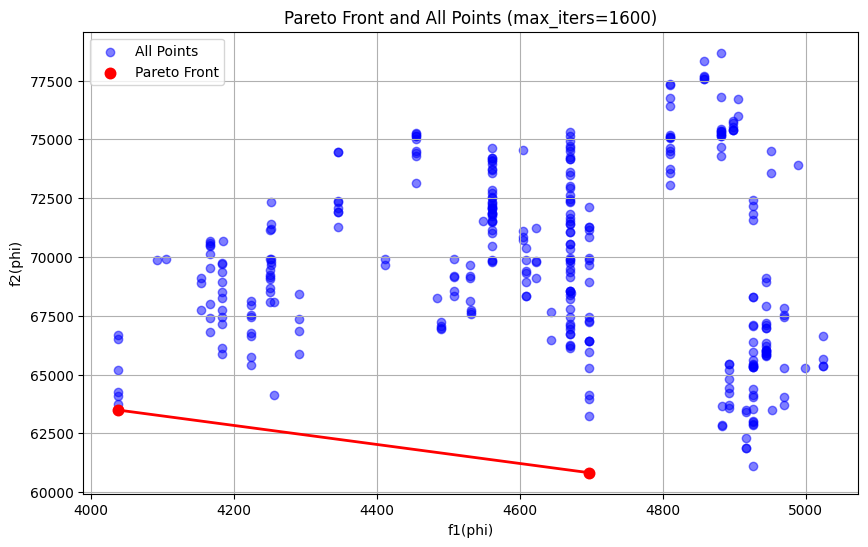

In [127]:
for iters, F, P in results:
    plt.figure(figsize=(10, 6))

    P_arr = np.array(P)
    plt.scatter(P_arr[:, 0], P_arr[:, 1], label='All Points', color='blue', alpha=0.5)

    F_arr = np.array(F)
    sorted_indices = np.argsort(F_arr[:, 0])
    sorted_F = F_arr[sorted_indices]

    plt.scatter(sorted_F[:, 0], sorted_F[:, 1], label='Pareto Front', color='red', 
                s=50, edgecolor='red', linewidth=1.5, marker='o')
    plt.plot(sorted_F[:, 0], sorted_F[:, 1], color='red', linestyle='-', linewidth=2)

    plt.xlabel('f1(phi)')  # or adjust if plotting other criteria
    plt.ylabel('f2(phi)')  # or adjust if plotting other criteria
    plt.title(f'Pareto Front and All Points (max_iters={iters})')
    plt.legend()
    plt.grid(True)
    plt.show()

### OBLICZENIE HVI

In [ ]:
def area_under_nadir(pareto_front, reference_point):
    sorted_front = sorted(pareto_front, key=lambda x: x[0])

    hv = 0.0
    prev_f2 = reference_point[1]

    for f1, f2 in sorted_front:
        width = reference_point[0] - f1
        height = prev_f2 - f2
        hv += width * height
        prev_f2 = f2

    return hv

def compute_hvi_for_single_max_iter(repeats_for_one_iter, multiplier=1.2):
    all_points = []
    for _, F, _ in repeats_for_one_iter:
        all_points.extend(F)
    all_points = np.array(all_points)

    z1 = np.max(all_points[:, 0]) * multiplier
    z2 = np.max(all_points[:, 1]) * multiplier
    reference_point = [z1, z2]

    hvi_list = []
    for repetition, F, P in repeats_for_one_iter:
        hv = area_under_nadir(F, reference_point)
        hvi_list.append(hv)

    average_hvi = np.mean(hvi_list)

    return z1, z2, hvi_list, average_hvi

### WYPISANIE UŚREDIONEGO HVI

In [128]:
hvi_results = []
for i, repeats_for_one_iter in enumerate(results_for_hvi):
    z1, z2, hvi_list, average_hvi = compute_hvi_for_single_max_iter(repeats_for_one_iter)
    
    hvi_results.append((max_iters[i], z1, z2, hvi_list, average_hvi))
    
    print(f"Max Iterations: {max_iters[i]}, Average HVI: {average_hvi}")

Max Iterations: 100, Average HVI: 41232876.63999999
Max Iterations: 200, Average HVI: 44567472.05999999
Max Iterations: 400, Average HVI: 37626565.36
Max Iterations: 800, Average HVI: 40123084.45999999
Max Iterations: 1600, Average HVI: 43488389.84


### WYKRESY HVI

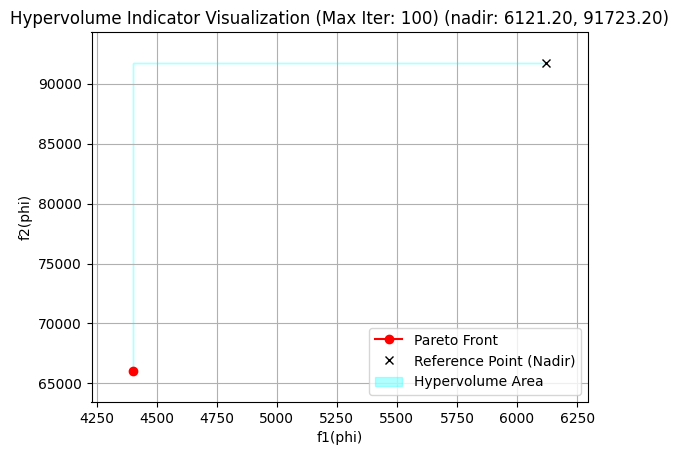

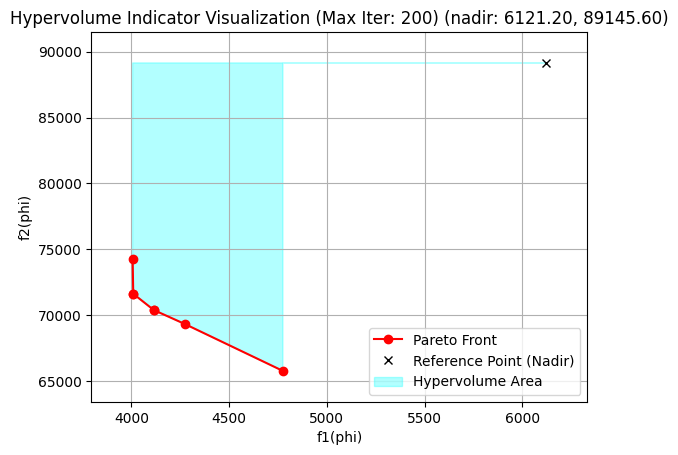

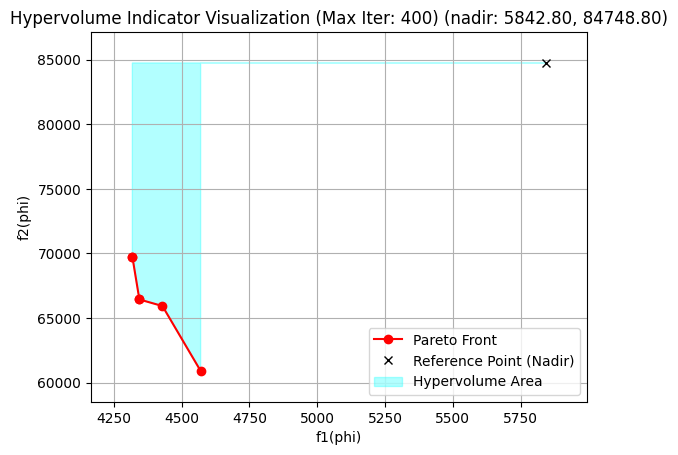

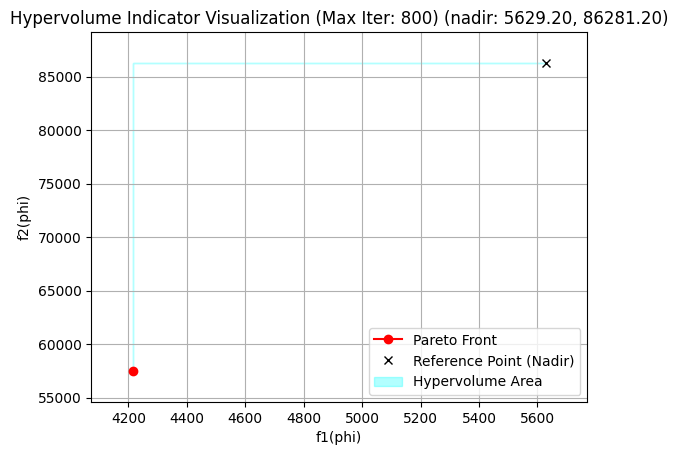

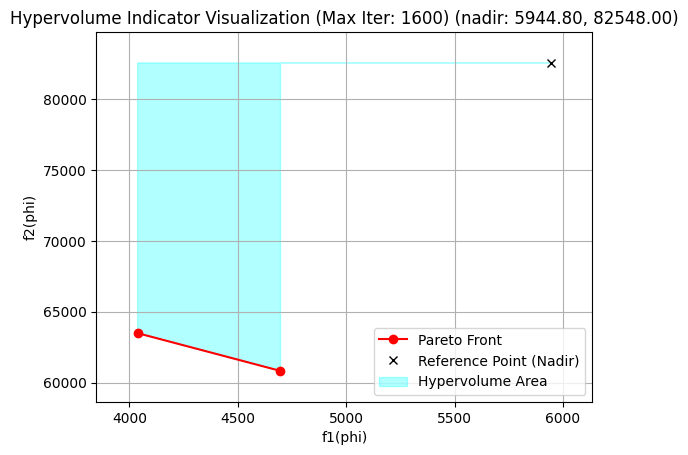

In [130]:
def plot_hvi_area(pareto_front, reference_point, max_iter: str):
    # Sort front by f1 ascending to ensure proper polygon shape
    front = sorted(pareto_front, key=lambda x: x[0])

    # Extract coordinates
    f1_vals = [p[0] for p in front]
    f2_vals = [p[1] for p in front]

    # Build polygon points
    polygon_points = []
    polygon_points.append(reference_point)
    polygon_points.append([front[0][0], reference_point[1]])
    polygon_points.extend(front)
    polygon_points.append([front[-1][0], reference_point[1]])
    polygon_points.append(reference_point)
    polygon_points = np.array(polygon_points)

    # Plot front points
    plt.plot(f1_vals, f2_vals, 'ro-', label='Pareto Front')

    # Plot reference point
    plt.plot(reference_point[0], reference_point[1], 'kx', label='Reference Point (Nadir)')

    # Fill hypervolume area
    plt.fill(polygon_points[:, 0], polygon_points[:, 1], color='cyan', alpha=0.3, label='Hypervolume Area')

    # Calculate plot limits to zoom in around front and reference point
    padding_ratio = 0.1  # 10% padding

    min_f1 = min(min(f1_vals), reference_point[0])
    max_f1 = max(max(f1_vals), reference_point[0])
    f1_range = max_f1 - min_f1
    x_min = min_f1 - padding_ratio * f1_range
    x_max = max_f1 + padding_ratio * f1_range

    min_f2 = min(min(f2_vals), reference_point[1])
    max_f2 = max(max(f2_vals), reference_point[1])
    f2_range = max_f2 - min_f2
    y_min = min_f2 - padding_ratio * f2_range
    y_max = max_f2 + padding_ratio * f2_range

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Labels and title
    plt.xlabel('f1(phi)')
    plt.ylabel('f2(phi)')
    title = 'Hypervolume Indicator Visualization'
    title += f' (Max Iter: {max_iter}) (nadir: {reference_point[0]:.2f}, {reference_point[1]:.2f})'
    plt.title(title)

    plt.legend()
    plt.grid(True)
    plt.show()
for max_iter, z1, z2, hvi_list, average_hvi in hvi_results:
    i = max_iters.index(max_iter)
    pareto_front = results_for_hvi[i][0][1]  
    plot_hvi_area(pareto_front, [z1, z2], max_iter=max_iter)